# SSD

This is to go through each important step of SSD.

Firstly, load the model. You only need to do this one time.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'

import numpy as np
import os
os.chdir('..')
caffe_root = './'
import sys
sys.path.insert(0, caffe_root + 'python')
import time

import caffe
from caffe.proto import caffe_pb2

caffe.set_device(0)
caffe.set_mode_gpu()
# caffe.set_mode_cpu()
# We create a solver that fine-tunes from a previously trained network.
solver = caffe.SGDSolver(caffe_root + 'models/VGGNet/VOC0712/SSD_300x300/solver.prototxt')
solver.net.copy_from(caffe_root + 'models/VGGNet/VGG_ILSVRC_16_layers_fc_reduced.caffemodel')

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': solver.net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

net = solver.net

In [2]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
labelmap_file = 'data/VOC0712/labelmap_voc.prototxt'
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in range(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

In [3]:
# Forward one step.
solver.step(1)

Now let's see the annotated datum after one forward-backward step.

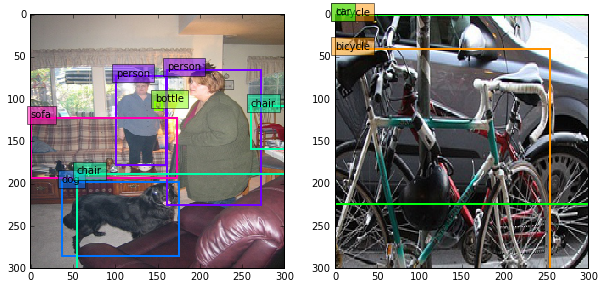

In [4]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

img_blob = net.blobs['data'].data
num_imgs = img_blob.shape[0]
img_height = img_blob.shape[2]
img_width = img_blob.shape[3]
label_blob = net.blobs['label'].data[0,0,:,:]
num_labels = label_blob.shape[0]

for i in range(num_imgs):
    img = transformer.deprocess('data', img_blob[i])
    plt.subplot(1, num_imgs, i + 1)
    plt.imshow(img)
    currentAxis = plt.gca()
    for j in range(num_labels):
        gt_bbox = label_blob[j, :]
        if gt_bbox[0] == i:
            xmin = gt_bbox[3] * img_width
            ymin = gt_bbox[4] * img_height
            xmax = gt_bbox[5] * img_width
            ymax = gt_bbox[6] * img_height
            gt_label = int(gt_bbox[1])
            coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
            color = colors[gt_label]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            label = get_labelname(labelmap, gt_bbox[1])[0]
            currentAxis.text(xmin, ymin, label, bbox={'facecolor':color, 'alpha':0.5})

In [5]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

Let's visualize the conv1_1's filters to make sure we have loaded a good pretrained model. Otherwise, it should plot random noise squares.

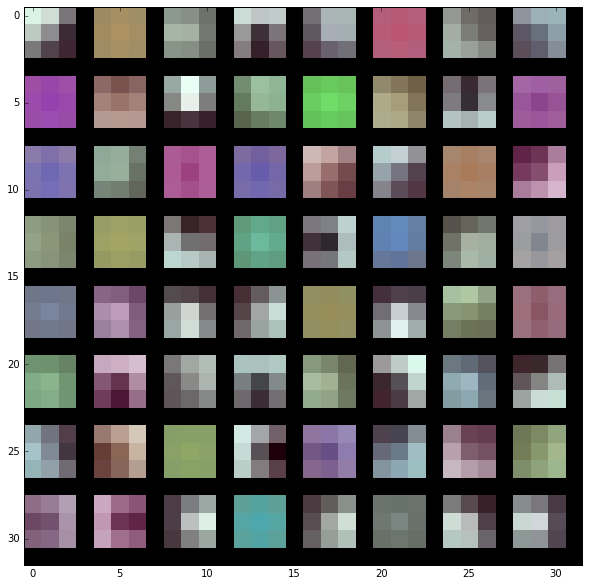

In [6]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1_1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

And let's visualize conv5_3 layer responses. You should see nicely pattern.

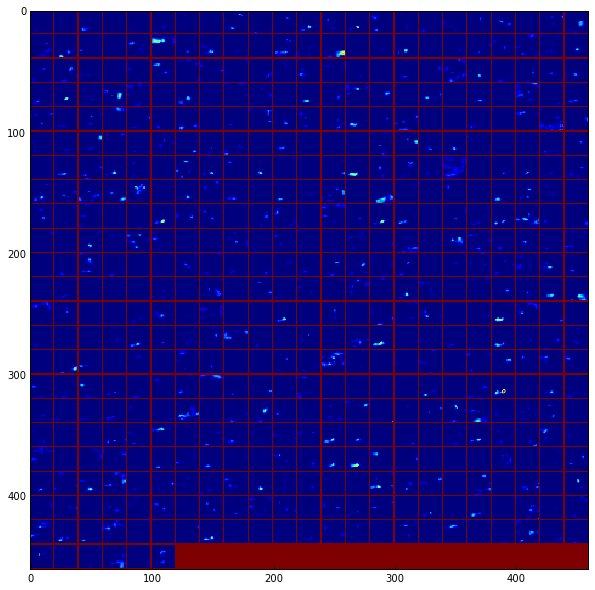

In [7]:
feat = net.blobs['conv5_3'].data[0, :]
vis_square(feat, padval=1)

Make sure that the PermuteLayer is doing the right thing.

In [8]:
fc7_mbox_loc = net.blobs['fc7_mbox_loc'].data
print(fc7_mbox_loc[0,:,1,2])

fc7_mbox_loc_perm = net.blobs['fc7_mbox_loc_perm'].data
print(fc7_mbox_loc_perm[0,1,2,:])

[ 0.07766187 -0.03464822 -0.3870728  -0.35575289  0.81836522 -0.39662695
 -0.72433686 -0.32558653 -0.17875659  0.71999502 -0.03263161  1.55859804
  0.21975756 -1.42426693 -0.37707359  0.42971838  0.06979506  0.11014652
 -0.42162776 -0.18646497  0.59345412 -0.57992661  0.28513384 -0.02586371]
[ 0.07766187 -0.03464822 -0.3870728  -0.35575289  0.81836522 -0.39662695
 -0.72433686 -0.32558653 -0.17875659  0.71999502 -0.03263161  1.55859804
  0.21975756 -1.42426693 -0.37707359  0.42971838  0.06979506  0.11014652
 -0.42162776 -0.18646497  0.59345412 -0.57992661  0.28513384 -0.02586371]


Make sure the PriorBoxLayer generates the correct priors.

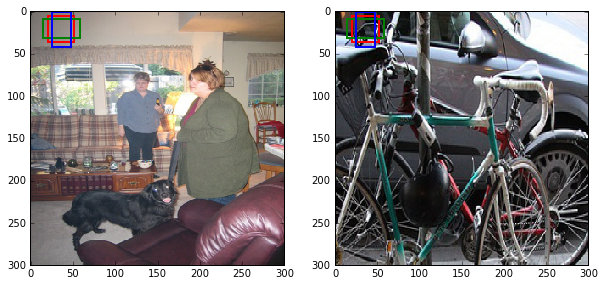

In [9]:
img_blob = net.blobs['data'].data
num_imgs = img_blob.shape[0]
img_height = img_blob.shape[2]
img_width = img_blob.shape[3]

priorbox = net.blobs['mbox_priorbox'].data[0,0,:]
num_priors = priorbox.shape[0]

colors='rgbcmy'
for i in range(num_imgs):
    img = transformer.deprocess('data', img_blob[i])
    plt.subplot(1, num_imgs, i + 1)
    plt.imshow(img)
    currentAxis = plt.gca()
    for j in range(240,243):
        prior_bbox = priorbox[j*4:(j+1)*4]
        xmin = prior_bbox[0] * img_width
        ymin = prior_bbox[1] * img_height
        xmax = prior_bbox[2] * img_width
        ymax = prior_bbox[3] * img_height
        coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=colors[j%4], linewidth=2))